# TensorFlow Object Detection API - End to End

# Complete all installations


In [1]:
%%capture

# Clone TF models repository from GitHUb
!git clone https://github.com/tensorflow/models

In [2]:
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install --quiet .

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


# Import required libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle

import tensorflow as tf

from sklearn import preprocessing

# Download Pascal VOC dataset

In [4]:
%%capture
%cd /content/ 
!mkdir Dataset 
%cd Dataset 

# Download xml_to_csv.py and generate-tfrecord.py
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/End_to_End_Training/xml_to_csv.py
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/End_to_End_Training/generate_tfrecord.py

#Get PASCAL VOC dataset
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar --quiet
# Unzip tar file
!tar -xf VOCtrainval_06-Nov-2007.tar

# Define images folder and XMLs folder

In [5]:
img_path = '/content/Dataset/VOCdevkit/VOC2007/JPEGImages/'
xml_path = '/content/Dataset/VOCdevkit/VOC2007/Annotations/'

# Data Pre-processing : Convert XML to CSV

In [6]:
# Convert XML to CSV using script
!python xml_to_csv.py -i {xml_path} -o annot_data.csv
print()

# Load CSV file as dataframe
annot_df = pd.read_csv('annot_data.csv')
display(annot_df.head(5))
print()

# Print number of images with annotations
print("Total number of images is %d" %(annot_df.shape[0]))
# Print number of unique classes in dataset
print("Number of unique classes is %d" %(len(annot_df['class'].unique())))

Successfully converted xml to csv.



,filename,width,height,class,xmin,ymin,xmax,ymax
0,002196.jpg,375,500,cat,4,2,375,500
1,000019.jpg,500,375,cat,231,88,483,256
2,000019.jpg,500,375,cat,11,113,266,259
3,001872.jpg,500,375,sheep,153,22,355,342
4,000303.jpg,500,377,car,15,39,500,280



Total number of images is 15607
Number of unique classes is 20


# Label encode classes

In [7]:
# Label Encode class and add a 'label' column to the dataframe
le = preprocessing.LabelEncoder()
annot_df['label'] = le.fit_transform(annot_df['class'])
# Object detection API expects index to start from 1 (and not 0)
annot_df['label'] = annot_df['label'] + 1

# Print list of unique classes and unique class labels
display(annot_df['class'].unique())
print()
display(annot_df['label'].unique())

array(['cat', 'sheep', 'car', 'bottle', 'person', 'sofa', 'diningtable',
       'chair', 'pottedplant', 'motorbike', 'tvmonitor', 'dog', 'boat',
       'aeroplane', 'cow', 'bicycle', 'horse', 'bus', 'bird', 'train'],
      dtype=object)

array([ 8, 17,  7,  5, 15, 18, 11,  9, 16, 14, 20, 12,  4,  1, 10,  2, 13,
        6,  3, 19])

In [8]:
# Create a dictionary mapping from Label to Class. 
label_class_dict = dict(zip(annot_df['label'], annot_df['class']))
print(label_class_dict)

{8: 'cat', 17: 'sheep', 7: 'car', 5: 'bottle', 15: 'person', 18: 'sofa', 11: 'diningtable', 9: 'chair', 16: 'pottedplant', 14: 'motorbike', 20: 'tvmonitor', 12: 'dog', 4: 'boat', 1: 'aeroplane', 10: 'cow', 2: 'bicycle', 13: 'horse', 6: 'bus', 3: 'bird', 19: 'train'}


# Create Label Mapping File

In [9]:
# Build a pbtxt label file using label and class name

pbtxt_file_str = '' # Initialize pbtxt file string

for label in sorted(label_class_dict.keys()):
  pbtxt_file_str += "item {\n  id: " + str(label) + "\n  name: '" +  label_class_dict[label] + "'\n}\n\n"

with open('label_map.txt','w') as pbfile:
    pbfile.write(pbtxt_file_str)

# Split data between training and test

In [10]:
# Get information on all images
all_images = annot_df['filename'].unique()
# Create train / test split (80% of data for training)
np.random.seed(0)
mask = np.random.rand(all_images.shape[0]) < 0.8

train_images = all_images[mask]
test_images = all_images[~mask] 

print("Number of train_images is %d" %(len(train_images)))
print("Number of test_images is %d" %(len(test_images)))
print()

# Split dataframe between training and test
train_df = annot_df[annot_df['filename'].isin(train_images)]
test_df = annot_df[annot_df['filename'].isin(test_images)]

print("Size of train_df is %d" %train_df.shape[0])
print("Size of test_df is %d" %test_df.shape[0])

Number of train_images is 4000
Number of test_images is 996

Size of train_df is 12591
Size of test_df is 3016


# Visualizing some images with BBoxes

## Training set

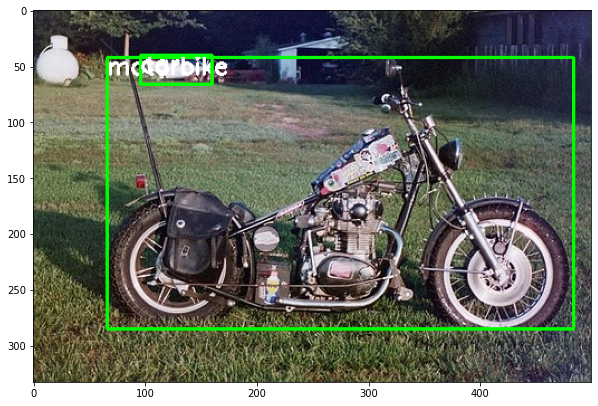

In [11]:
# Pickup a random image number
samp_ind = np.random.randint(0, train_df.shape[0], 1)[0]

# Read the image
img_file = train_df.iloc[samp_ind,0]
img = cv2.imread(img_path + '/' + img_file)

# Find all rows which have same file name
all_rows = train_df[train_df['filename'] == img_file].index.tolist()

# Draw BBoxes along with labels
for ind in all_rows:

    # Get bounding box co-ords
    xmin, ymin, xmax, ymax = train_df.loc[ind, ['xmin', 'ymin', 'xmax', 'ymax']]
    # Get Class of object
    obj_class = train_df.loc[ind, 'class']
    # Draw BBox
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    # Add text
    cv2.putText(img, obj_class, (xmin, ymin + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw image using matplotlib
plt.figure(figsize = (10,7))
plt.imshow(img)
plt.show()

## Test Set

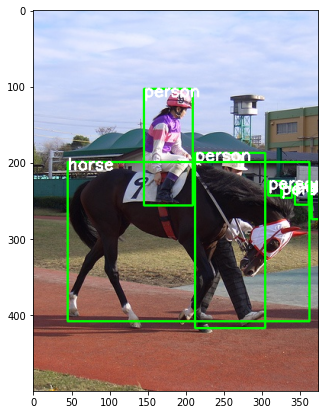

In [12]:
# Pickup a random image number
samp_ind = np.random.randint(0, test_df.shape[0], 1)[0]

# Read the image
img_file = test_df.iloc[samp_ind, 0]
img = cv2.imread(img_path + '/' + img_file)

# Find all rows which have same file name
all_rows = test_df[test_df['filename'] == img_file].index.tolist()

# Draw BBoxes along with labels
for ind in all_rows:

    # Get bounding box co-ords
    xmin, ymin, xmax, ymax = test_df.loc[ind, ['xmin', 'ymin', 'xmax', 'ymax']]
    # Get Class of object
    obj_class = test_df.loc[ind, 'class']
    # Draw BBox
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    # Add text
    cv2.putText(img, obj_class, (xmin, ymin + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw image using matplotlib
plt.figure(figsize = (10,7))
plt.imshow(img)
plt.show()

# Save training and test data as csv

In [13]:
train_df.to_csv('train.csv', index = False)
test_df.to_csv('test.csv', index = False)

# Generate tfrecord from CSV


In [14]:
%%capture

#Generate tfrecord for training data
!python generate_tfrecord.py --csv_input=train.csv --img_path={img_path} --output_path=train.tfrecord
#Generate tfrecord for test data
!python generate_tfrecord.py --csv_input=test.csv --img_path={img_path} --output_path=test.tfrecord

# Download a pre-trained model

A list of pre-trained models is available at [TensorFlow model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). We will use 'ssd_mobilenet_v1_coco' model for transfer learning.

In [15]:
%%capture

# Download the model from zoo
!wget -q http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
# Extract tar file
!tar -xf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
# Delete tar file
!rm ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

# Complete setups required for training

## Prepare Training configuration file

A sample configuration for the chosen pre-trained model (SSD MobileNet v2 320x320) is copied from [Configs](https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2) folder. The following updates have been made to 'ssd_mobilenet_v2_modified.config' file which is loaded from GitHub below:

1. 'num_classes' parameter set to 20 (as we have 20 categories in pascal voc dataset).
2. For 'train_input_reader' 'input_path' set to 'train.tfrecord' (Location of train.tfrecord file).
3. For 'train_input_reader' 'label_map_path' set to 'label_map.txt' (path of label_map.txt file).
4. For 'eval_input_reader' 'input_path' set to 'test.tfrecord' (Location of test.tfrecord file).
5. For 'eval_input_reader' 'label_map_path' set to 'label_map.txt' (path of label_map.txt file).
5. 'fine_tune_checkpoint' set to "ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0"  (filepath of pree-trained model checkpoint file).
6. 'batch_size' set to 24. 
7. 'num_steps' set as per requirements of each run. 


## Load training configuration file

In [20]:
%%capture

!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/End_to_End_Training/ssd_mobilenet_v2_modified.config
config_file = 'ssd_mobilenet_v2_modified.config'

In [ ]:
#!cat ssd_mobilenet_v2_modified.config

## Copy model training script

In [18]:
# Copy training file from 'models/research/object_detection' folder to current folder
!cp /content/models/research/object_detection/model_main_tf2.py .

## Create training folder

In [19]:
# Create a training folder to store model checkpoints/snapshots as training progresses
!mkdir training

## Launch Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir training
#%reload_ext tensorboard

# Train the model

In [ ]:
# Start training
# model_dir=training/ (path where outputs from model will be stored)
# pipeline_config_path={config_file} (config file that will be used for training and evaluation)
# checkpoint_every_n=100 (Checkpoint every 100 steps)
!python model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_every_n=100 --alsologtostderr

# Evaluate Model on Test set

In [ ]:
# Start Evaluation
# Setting checkpoint_dir=training will set the model to eval-only mode.
# Results will be written to model_dir
!python model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_dir=training/ --alsologtostderr 

# Training and Evaluation in Background

If we want to evaluate our model on training data regularly, we have to run both training and evaluation script in parallel. Model evaluation on test data gets done everytime model checkpoint is saved during training.

In [ ]:
  #Start training
!nohup /usr/bin/python3 model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_every_n=500 --alsologtostderr --eval_training_data --sample_1_of_n_eval_on_train_examples=10  > train.txt 2>&1 &

In [ ]:
!nohup /usr/bin/python3 model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_dir=training/ --alsologtostderr > eval.txt 2>&1 &

In [ ]:
!cat train.txt

In [ ]:
!cat eval.txt

In [ ]:
#Check the training folder
!ls -l training

# Export trained model

From the saved model checkpoints, we will create a frozen trained model. Frozen here means to remove model nodes which are no longer needed in prediction. This reduces model size.

In [31]:
# Copy export_inference_graph.py file from models/research/object_detection to current directory
!cp /content/models/research/object_detection/exporter_main_v2.py .

In [32]:
# Provide input name, config file location, training folder
# input_type "image_tensor" => Input to model should be 4D tensor of shape [1, None, None, 3]
# Model will be created in output_directory. Directory will be created if it doesn't exist
!python exporter_main_v2.py --input_type "image_tensor" --pipeline_config_path {config_file} --trained_checkpoint_dir training/ --output_directory detection_model

2021-04-29 04:42:55.952887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-29 04:42:58.160835: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-29 04:42:58.161654: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-29 04:42:58.192057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-29 04:42:58.192661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-04-29 04:42:58.192700: I tensorflow/stream_executor/platform/default/dso_loade

# Copy the trained model to Google Drive

## Connect to Google Drive

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Save detection_model to drive

In [34]:
!cp -r detection_model '/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/SSD_Model_Trained_Pascal_VOC' 

## Save label class dictionary to drive

In [38]:
label_file_path = '/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/SSD_Model_Trained_Pascal_VOC/pascal_voc_label.pkl'
with open(label_file_path,'wb') as file:
    pickle.dump(label_class_dict, file)

# Model Prediction

Load Saved model

In [ ]:
saved_model_path = 'detection_model/saved_model'
model = tf.saved_model.load(saved_model_path)

Function to get model prediction

In [ ]:
#Function to get predictions from a Detection model
def detector_prediction(image_file, confidence_threshold=0.5):

    """
    image_file: File path of the image for which prediction needs to be done
    confidence_threshold: Minimum confidence/probability for prediction to be considered
    """
    #Load image
    img = tf.keras.preprocessing.image.load_img(image_file)
    
    #Convert to numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')
    #Make it a batch of one example
    img_array = tf.expand_dims(img_array, axis=0)

    #Prediction
    output = model(img_array) #get list of tensors discussed above as output
    #print(output)
    detection_scores = output['detection_scores'].numpy()[0] #get detection scores
    detection_classes = output['detection_classes'].numpy()[0]
    detection_boxes = output['detection_boxes'].numpy()[0]

    #Select predictions for which probability is higher than confidence_threshold
    selected_predictions = detection_scores >= confidence_threshold

    selected_prediction_scores = detection_scores[selected_predictions]
    selected_prediction_classes = detection_classes[selected_predictions]
    selected_prediction_boxes = detection_boxes[selected_predictions]

    #De-normalize box co-ordinates (multiply x-coordinates by image width and y-coords by image height)
    img_w, img_h = img.size

    for i in range(selected_prediction_boxes.shape[0]):
        
        selected_prediction_boxes[i,0] *= img_h #ymin * img_w
        selected_prediction_boxes[i,1] *= img_w #xmin * img_h
        selected_prediction_boxes[i,2] *= img_h #ymax * img_w
        selected_prediction_boxes[i,3] *= img_w #xmax * img_h

    #Make all co-ordinates as integer
    selected_prediction_boxes= selected_prediction_boxes.astype(int)

    #Convert class indexes to actual class labels
    predicted_classes = []
    for i in range(selected_prediction_classes.shape[0]):
        predicted_classes.append(label_class_dict[int(selected_prediction_classes[i])])

    #Number of predictions
    selected_num_predictions = selected_prediction_boxes.shape[0]

    return {'Total Predictions': selected_num_predictions,
            'Scores': selected_prediction_scores, 
            'Classes': predicted_classes, 
            'Box coordinates': selected_prediction_boxes}

Copy an image to predict on

In [ ]:
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/End_to_End_Training/person_with_bike.jpg

In [ ]:
!cp '/gdrive/MyDrive/AI_ML_Folder/Colab_Directory/TF_ObjDet/person_with_bike.jpg' .

In [ ]:
#Model output
detector_prediction('person_with_bike.jpg', confidence_threshold=0.2)

Visualize model output

In [ ]:
import cv2
from matplotlib import pyplot as plt

In [ ]:
def visualize_output(image_file, confidence_threshold=0.5):

    #Call model prediction function above
    output = detector_prediction(image_file, confidence_threshold=confidence_threshold)

    #Read image
    img = cv2.imread(image_file)

    #Draw rectangle for predicted boxes, also add predicted classes
    for i in range(output['Box coordinates'].shape[0]):

        box = output['Box coordinates'][i]
        
        #Draw rectangle - (ymin, xmin, ymax, xmax)
        img = cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (0,255,0), 2)
        
        #Add Label - Class name and confidence level
        label = output['Classes'][i] + ': ' + str(round(output['Scores'][i],2))
        img = cv2.putText(img, label, (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    #Conver BGR image to RGB to use with Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Display image
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.show()

In [ ]:
#Visualize on image
visualize_output('person_with_bike.jpg', confidence_threshold=0.4)

In [ ]:
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/Pretrained_Model_Inference_Only/Images.zip

In [ ]:
!unzip Images.zip

In [ ]:
img_file_path = "/content/Dataset/Images/image1.jpg"
detector_prediction(img_file_path, confidence_threshold = 0.2)

In [ ]:
visualize_output(img_file_path, confidence_threshold=0.5)